In [1]:
'''
1. データセット用フォルダー「data」と
    学習済みの重み用フォルダー「weights」の作成
'''
import os

# 「data」フォルダーの作成
data_dir = './data'
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

# 「weights」フォルダーの作成
weights_dir = './weights'
if not os.path.exists(weights_dir):
    os.mkdir(weights_dir)

In [2]:
%%time
'''
2. VOC2012のデータセットを
    Visual Object Classes Challenge 2012 (VOC2021)のサイトからダウンロード
'''
import urllib.request
import tarfile

url = 'http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar'
# data_dirファイル名を連結してファイルパスを作成
target_path = os.path.join(data_dir, 'VOCtrainval_11-May-2012.tar')

if not os.path.exists(target_path):
    # urlにアクセスしてファイルパスtarget_pathとしてダウンロード
    urllib.request.urlretrieve(url, target_path)
    # ダウンロードしたtar形式ファイルを読み込み
    tar = tarfile.TarFile(target_path)
    tar.extractall(data_dir)
    tar.close()

CPU times: user 9.08 s, sys: 10.6 s, total: 19.7 s
Wall time: 3min 9s


In [3]:
%%time
'''
3. SSDで使用するVGG16の学習済みの重みを
    「weights」フォルダーにダウンロード
'''
url = 'https://s3.amazonaws.com/amdegroot-models/vgg16_reducedfc.pth'
# weights_dirにファイル名を連結してファイルパスを作成
target_path = os.path.join(weights_dir, 'vgg16_reducedfc.pth')

if not os.path.exists(target_path):
    # urlにアクセスしてファイルパスtarget_pathとしてダウンロード
    urllib.request.urlretrieve(url, target_path)

CPU times: user 190 ms, sys: 164 ms, total: 354 ms
Wall time: 8.23 s


In [4]:
%%time
'''
4. SSD300の学習済みの重みを
    「weights」フォルダーにダウンロード
'''
url = 'https://s3.amazonaws.com/amdegroot-models/ssd300_mAP_77.43_v2.pth'
# weights_dirにファイル名を連結してファイルパスを作成
target_path = os.path.join(weights_dir, 'ssd300_mAP_77.43_v2.pth')

if not os.path.exists(target_path):
    # urlにアクセスしてファイルパスtarget_pathとしてダウンロード
    urllib.request.urlretrieve(url, target_path)

CPU times: user 252 ms, sys: 225 ms, total: 477 ms
Wall time: 8.56 s


In [5]:
'''
1. 訓練、検証のイメージとアノテーションのファイルパスのリストを作成する関数
'''
import os.path as osp

def make_filepath_list(rootpath):
    '''
    データのパスを格納したリストを作成する
    Parameters:
        rootpath(str): データフォルダーのルートパス
    Returns:
        train_img_list : 訓練用イメージのパスリスト
        train_anno_list : 訓練用アノテーションのパスリスト
        val_img_list : 検証用イメージのパスリスト
        val_anno_list : 検証用アノテーションのパスリスト
    '''
    # 画像ファイルとアノテーションファイルへのパスのテンプレートを作成
    imgpath_template = osp.join(rootpath, 'JPEGImages', '%s.jpg')
    annopath_template = osp.join(rootpath, 'Annotations', '%s.xml')

    # 訓練と検証、それぞれのファイルのID（ファイル名）を取得する
    train_id_names = osp.join(rootpath + 'ImageSets/Main/train.txt')
    val_id_names = osp.join(rootpath + 'ImageSets/Main/val.txt')

    # 訓練データの画像ファイルとアノテーションファイルへのパスを保存するリスト
    train_img_list = list()
    train_anno_list = list()

    for line in open(train_id_names):
        file_id = line.strip()
        # %sをファイルIDに置き換えて画像のパスを作る
        img_path = (imgpath_template % file_id)
        # %sをファイルIDに置き換えてアノテーションのパスを作る
        anno_path = (annopath_template % file_id)
        train_img_list.append(img_path)
        train_anno_list.append(anno_path)
    
    # 検証データの画像ファイルとアノテーションファイルへのパスリストを作成
    val_img_list = list()
    val_anno_list = list()

    for line in open(val_id_names):
        file_id = line.strip()
        img_path = (imgpath_template % file_id)
        anno_path = (annopath_template % file_id)
        val_img_list.append(img_path)
        val_anno_list.append(anno_path)
    
    return train_img_list, train_anno_list, val_img_list, val_anno_list

In [7]:
# make_filepath_list()の動作確認
rootpath = './data/VOCdevkit/VOC2012/'
# ファイルパスのリストを作成
tr_img, tr_anno, val_img, val_anno = make_filepath_list(rootpath)

# 各リストの先頭要素を出力
print(tr_img[0])
print(tr_anno[0])
print(val_img[0])
print(val_anno[0])

./data/VOCdevkit/VOC2012/JPEGImages/2008_000008.jpg
./data/VOCdevkit/VOC2012/Annotations/2008_000008.xml
./data/VOCdevkit/VOC2012/JPEGImages/2008_000002.jpg
./data/VOCdevkit/VOC2012/Annotations/2008_000002.xml


In [11]:
'''
2. バウンディングボックスの座標と正解ラベルをリスト化するクラス
'''
import xml.etree.ElementTree as ElementTree
import numpy as np

class GetBBoxAndLabel(object):
    '''
    1枚の画像のアノテーション
    (BBOXの座標、ラベルのインデックスr)をNumpy配列を返す
    Attributes:
        classes(list): VOCのクラス名(str)を格納したリスト
    '''
    def __init__(self, classes):
        '''
        インスタンス変数のクラスのリストに格納する
        Parameters:
            classes(list): VOCのクラス名(str)を格納したリスト
        '''
        self.classes = classes
    
    def __call__(self, xml_path, width, height):
        '''
        インスタンスから実行されるメソッド
        1枚の画像のアノテーションデータをリスト化して多重リストにまとめる
        バウンディングボックスの各座標は画像サイズで割り算して正規化する
        Parameters:
            xml_path(str): xmlファイルのパス
            width(int): イメージの幅（正規化に必要）
            height(int): イメージの高さ（正規化に必要）
        Returns:
            [[xmin, ymin, xmax, ymax, ラベルのインデックス]]
            要素数は画像内に存在するobjectの数と同じ
        '''
        # 画像内の全ての物体のアノテーションを格納するリスト
        annotation = []

        # アノテーションのxmlファイルを読み込む
        xml = ElementTree.parse(xml_path).getroot()

        # イメージの中の物体（object）の数だけループする
        for obj in xml.iter('object'):
            # アノテーションで検知がdifficultのものは除外
            # difficultの値（0または1）をtextで取得してint型に変換
            # difficult==1の物体は処理せずにforの先頭に戻る
            difficult = int(obj.find('difficult').text)
            if difficult == 1:
                continue

            # 1つの物体に対するアノテーションを格納するリスト
            bndbox = []

            # <name>の要素（物体名）名を抽出
            # 小文字に変換後、両端の空白削除
            name = obj.find('name').text.lower().strip()
            # <bndbox>を取得
            bbox = obj.find('bndbox')

            # アノテーションのxmin, ymin, xmax, ymaxを取得し、0~1に規格化
            grid = ['xmin', 'ymin', 'xmax', 'ymax']

            for gr in (grid):
                # バウンディングボックスの座標<xmin><ymin><xmax><ymax>を取得
                # VOCは原点が（1、1）なので1を引き算して
                # 各オフセットの原点を（0、0）の状態にする
                axis_value = int(bbox.find(gr).text) - 1
                # バウンディングボックスの座標を正規化
                if gr == 'xmin' or gr == 'xmax':
                    # xmin, xmaxの値のイメージの幅で割り算
                    axis_value /= width
                else:
                    # ymin, ymaxの値はイメージの高さで割り算
                    axis_value /= height
                # xmin, ymin, xmax, ymaxを値を順にbndboxに追加
                bndbox.append(axis_value)
            
            # 物体名のインデックスを取得
            label_idx = self.classes.index(name)
            # bndboxにインデックスを追加して物体のアノテーションリストを完成
            bndbox.append(label_idx)

            # 全てのアノテーションリストをannotationに格納
            annotation += [bndbox]
        
        # 多重リスト[xmin, ymin, xmax, ymax, 正解ラベルのインデックス]
        # を2次元のNumpy配列に変換
        return np.array(annotation)

In [12]:
# GetBoxAndLabelクラスの動作確認
import cv2

# VOC2012に正解ラベルのリスト
voc_labels = [
    'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
    'bus', 'car', 'cat', 'chair', 'cow',
    'diningrable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]

# 正解ラベルを引数にしてGetBBoxAndLabelを生成
annotation = GetBBoxAndLabel(voc_labels)

# 検証データの2番目のイメージを読み込む
index = 1
img_path = val_img[index]
# OpenCV2でイメージのデータ
# (高さのピクセル数、幅にピクセル数、」BGR(3))のndarrayを取得
img = cv2.imread(img_path)
# ndarrayの要素数を数えて、イメージの高さと幅のみを取得
heigth, width, _ = img.shape

# 2番目のイメージのアノテーションをリストにする
annotation(
    val_anno[index],
    width,
    heigth
)

array([[ 0.09      ,  0.03003003,  0.998     ,  0.996997  , 18.        ],
       [ 0.122     ,  0.56756757,  0.164     ,  0.72672673, 14.        ]])

In [117]:
'''
1. データの拡張処理を行うクラス
'''
import cv2
import numpy as np
from numpy import random

class Compose(object):
    def __init__(self, transform):
        '''
        Args:
            transforms (List[Transform): 変換処理のリスト
        Example:
            augmentations.Compose([
                transforms.CenterCrop(10),
                transforms.ToTensor()
            ])
        '''
        self.transforms = transform
    
    def __call__(self, img, boxes=None, labels=None):
        for t in self.transforms:
            img, boxes, labels = t(img, boxes, labels)
        return img, boxes, labels

In [118]:
'''
2. ピクセルデータのint型をfloat32に変換するクラス
'''
class ConvertFromInts(object):
    def __call__(self, image, boxes=None, labels=None):
        return image.astype(np.float32), boxes, labels

In [119]:
'''
3. アノテーションデータの正規化を元の状態に戻すクラス
'''
class ToAbsoluteCoords(object):
    def __call__(self, image, boxes=None, labels=None):
        height, width, channels = image.shape
        boxes[:, 0] *= width
        boxes[:, 2] *= width
        boxes[:, 1] *= height
        boxes[:, 3] *= height

        return image, boxes, labels

In [120]:
'''
4. 輝度（明るさ）をランダムに変化させるクラス
'''
class RandomBrightness(object):
    def __init__(self, delta=32):
        assert delta >= 0.0
        assert delta <= 255.0
        self.delta = delta

    def __call__(self, image, boxes=None, labels=None):
        if random.randint(2):
            delta = random.uniform(-self.delta, self.delta)
            image += delta
        return image, boxes, labels

In [121]:
'''
5. コントラストをランダムに変化させるクラス
'''
class RandomContrast(object):
    def __init__(self, lower=0.5, upper=1.5):
        self.lower = lower
        self.upper = upper
        assert self.upper >= self.lower, 'contrast upper must be >= lower.'
        assert self.lower >= 0, 'contrast lower must be non-negative.'
    
    # expects float image
    def __call__(self, image, boxes=None, labels=None):
        if random.randint(2):
            alpha = random.uniform(self.lower, self.upper)
            image *= alpha
        
        return image, boxes, labels

In [122]:
'''
6. BGRとHSVを相互変換するクラス
'''
class ConvertColor(object):
    def __init__(self, current='BGR', transform='HSV'):
        self.current = current
        self.transform = transform
    
    def __call__(self, image, boxes=None, labels=None):
        if self.current == 'BGR' and self.transform == 'HSV':
            image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        elif self.current == 'HSV' and self.transform == 'BGR':
            image = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)
        else:
            raise NotImplementedError
        return image, boxes, labels

In [123]:
'''
7. 彩度をランダムに変化させるクラス
'''
class RandomSaturation(object):
    def __init__(self, lower=0.5, upper=1.5):
        self.lower = lower
        self.upper = upper
        assert self.upper >= self.lower, 'contrast upper must be >= lower.'
        assert self.lower >= 0, 'contrast lower must be non-negative.'
    
    def __call__(self, image, boxes=None, labels=None):
        if random.randint(2):
            image[:, :, 1] *= random.uniform(self.lower, self.upper)
        return image, boxes, labels

In [124]:
'''
8. ランダムに色相を変化させるクラス
'''
class RandomHue(object):
    def __init__(self, delta=18.0):
        assert delta >= 0.0 and delta <= 360.0
        self.delta = delta
    
    def __call__(self, image, boxes=None, labels=None):
        if random.randint(2):
            image[:, :, 0] += random.uniform(-self.delta, self.delta)
            image[:, :, 0][image[:, :, 0] > 360.0] -= 360.0
            image[:, :, 0][image[:, :, 0] < 0.0] += 360.0
        return image, boxes, labels

In [125]:
'''
9. 測光に歪みを加えるクラス
'''
class RandomLightingNoise(object):
    def __init__(self):
        self.perms = (
            (0, 1, 2), (0, 2, 1),
            (1, 0, 2), (1, 2, 0),
            (2, 0, 1), (2, 1, 0),
        )
    
    def __call__(self, image, boxes=None, labels=None):
        if random.randint(2):
            swap = self.perms[random.randint(len(self.perms))]
            shuffle = SwapChannels(swap)
            image = shuffle(image)
        return image, boxes, labels

In [126]:
'''
10. 色チャネルの並び替えを変えるクラス
'''
class SwapChannels(object):
    def __init__(self, swaps):
        '''
        Args:
            swaps (int triple): final order of channels
                eg: (2, 1, 0)
        '''
        self.swaps = swaps
    
    def __call__(self, image):
        '''
        Args:
            image (Tensor): image tensor to be transforned
        Return:
            a tensor with channels swapped according to swap
        '''
        image = image[:, :, self.swaps]
        return image

In [127]:
'''
11. 輝度、彩度、色相、コントラストを変化させ、歪みを加えるクラス
'''
class PhotometricDistort(object):
    def __init__(self):
        self.pd = [
            # コントラスト（RGBに適用）
            RandomContrast(),
            # カラーモデルをHSVにコンバート
            ConvertColor(transform='HSV'),
            # 彩度の変化（HSVに適用）
            RandomSaturation(),
            # 色相の変化（HSVに適用）
            RandomHue(),
            # カラーモデルをHSVからBGRにコンバート
            ConvertColor(current='HSV', transform='BGR'),
            # コントラストの変化（BGRに適用）
            RandomContrast()
        ]
        # 輝度
        self.rand_brightness = RandomBrightness()
        # 測光の歪み
        self.rand_light_noise = RandomLightingNoise()
    
    def __call__(self, image, boxes, labels):
        im = image.copy()
        # 明るさの変化
        im, boxes, labels = self.rand_brightness(im, boxes, labels)
        # 彩度、色相、コントラストの適用は上限と下限の間でランダムに
        # 歪みオフセットを選択することにより確率0.5で適用
        if random.randint(2):
            distort = Compose(self.pd[:-1])
        else:
            distort = Compose(self.pd[1:])
        # 彩度、色相、コントラストの適用
        im, boxes, labels = distort(im, boxes, labels)
        return self.rand_light_noise(im, boxes, labels)

In [128]:
'''
12. イメージをランダムに拡大するクラス
'''
class Expand(object):
    def __init__(self, mean):
        self.mean = mean
    
    def __call__(self, image, boxes, labels):
        if random.randint(2):
            return image, boxes, labels
        
        height, width, depth = image.shape
        ratio = random.uniform(1, 4)
        left = random.uniform(0, width * ratio - width)
        top = random.uniform(0, height * ratio - height)

        expand_image = np.zeros(
            (int(height * ratio), int(width * ratio), depth),
            dtype=image.dtype
        )
        expand_image[:, :, :] = self.mean
        expand_image[int(top):int(top + height), int(left):int(left + width)] = image
        image = expand_image

        boxes = boxes.copy()
        boxes[:, :2] += (int(left), int(top))
        boxes[:, 2:] += (int(left), int(top))

        return image, boxes, labels

In [129]:
'''
13. イメージの左右をランダムに反転するクラス
'''
class RandomMirror(object):
    def __call__(self, image, boxes, classes):
        _, width, _ = image.shape
        if random.randint(2):
            image = image[:, ::-1]
            boxes = boxes.copy()
            boxes[:, 0::2] = width - boxes[:, 2::-2]
        return image, boxes, classes

In [130]:
'''
14. アノテーションデータを0〜1.0の範囲に正規化するクラス
'''
class ToPercentCoords(object):
    def __call__(self, image, boxes=None, labels=None):
        heigth, width, channels = image.shape
        boxes[:, 0] /= width
        boxes[:, 2] /= width
        boxes[:, 1] /= heigth
        boxes[:, 3] /= heigth
        return image, boxes, labels

In [131]:
'''
15. イメージのサイズをinput_sizeにリサイズするクラス
'''
class Resize(object):
    def __init__(self, size=300):
        self.size = size

    def __call__(self, image, boxes=None, labels=None):
        image = cv2.resize(image, (self.size, self.size))
        return image, boxes, labels

In [138]:
'''
16. 色情報（RGB値）から平均値を引き算するクラス
'''
class SubtractMeans(object):
    def __init__(self, mean):
        self.mean = np.array(mean, dtype=np.float32)

    def __call__(self, image, boxes=None, labels=None):
        image = image.astype(np.float32)
        image -= self.mean
        return image.astype(np.float32), boxes, labels

In [139]:
'''
17. 2セットのBBoxの重なる部分を抽出する
'''
def intersect(box_a, box_b):
    max_xy = np.minimum(box_a[:, 2:], box_b[2:])
    min_xy = np.minimum(box_a[:, :2], box_b[:2])
    inter = np.clip((max_xy - min_xy), a_min=0, a_max=np.inf)
    return inter[:, 0] * inter[:, 1]

In [140]:
'''
18. 2セットのBBoxの類似度を示すジェッカード係数を計算する
'''
def jaccard_numpy(box_a, box_b):
    inter = intersect(box_a, box_b)
    area_a = ((box_a[:, 2] - box_a[:, 0]) * (box_a[:, 3] - box_a[:, 1]))
    area_b = ((box_b[2] - box_b[0]) * (box_b[3] - box_b[1]))
    union = area_a + area_b - inter
    return inter / union

In [141]:
'''
19. イメージの特定の領域をランダムに切り出すクラス
'''
class RandomSampleCrop(object):
    '''
    イメージの切り出しに合わせてバウンディングボックスも変形させる
    Argumentes:
        img (Image): トレーニング中に入力されるイメージ
        boxes (Tensor): オリジナルのバウンディングボックス
        lables (Tensor): バウンディングボックスのラベル
        mode (float tuple): 2セットのBBoxの類似度を示すジャッカード係数
    Returns:
        (img, boxes, classes)
            img (Image): トリミングされたイメージ
            boxes (Tensor): 調整後のバウンディングボックス
            labels (Tensor): バウンディングボックスのラベル
    '''
    def __init__(self):
        self.sample_options = (
            # 元の入力イメージ全体を使用
            None,
            # sample a patch s.t. MIN jaccard w/ obj in .1,.3,.4,.7,.9
            (0.1, None),
            (0.3, None),
            (0.7, None),
            (0.9, None),
            # バッチをランダムにサンプリング
            (None, None)
        )
        # オリジナルの実装ではタプルの要素のサイズが異なるため警告が出る
        # 警告を回避するためにobject型のndarrayに変換する
        self.sample_options = np.array(self.sample_options, dtype=object)
    
    def __call__(self, image, boxes=None, labels=None):
        height, width, _ = image.shape
        while True:
            # ランダムにモードを選択
            mode = random.choice(self.sample_options)
            if mode is None:
                return image, boxes, labels
            
            min_iou, max_iou = mode
            if min_iou is None:
                min_iou = float('-inf')
            if max_iou is None:
                max_iou = float('inf')
            
            # トレースの最大値（50）
            for _ in range(50):
                current_image = image

                w = random.uniform(0.3 * width, width)
                h = random.uniform(0.3 * height, height)

                # アスペクト比 constraint b/t .5 & 2
                if h / w < 0.5 or h / w > 2:
                    continue
                
                left = random.uniform(width - w)
                top = random.uniform(height - h)

                # イメージからトリミングする領域を作る
                # x1,y1,x2,y2を整数（int）に変換
                rect = np.array([int(left), int(top), int(left + w), int(top + h)])

                # オリジナルのBBoxとトリミング領域の
                # IoU（ジャッカードオーバーラップ）を計算
                overlap = jaccard_numpy(boxes, rect)

                # 最小及び最大のオーバーラップ制約が満たされていなければ再試行
                if overlap.min() < min_iou and max_iou < overlap.max():
                    continue
                
                # イメージから切り抜く
                current_image = current_image[rect[1]:rect[3], rect[0]:rect[2], :]

                # gt boxとサンプリングされたバッチのセンターを合わせる
                centers = (boxes[:, :2] + boxes[:, 2:]) / 2.0

                # 左上側にある全てのgtボックスをマスクする
                m1 = (rect[0] > centers[:, 0]) * (rect[1] < centers[:, 1])

                # 右上側にある全てのgtボックスをマスクする
                m2 = (rect[2] > centers[:, 0]) * (rect[3] < centers[:, 1])

                mask = m1 * m2

                # 有効なボックスがなけらば再試行
                if not mask.any():
                    continue
                
                # gtボックスを取得
                current_boxes = boxes[mask, :].copy()

                # ラベルを取得
                current_labels = labels[mask]

                # ボックスの左上隅を使用する
                current_boxes[:, :2] = np.maximum(current_boxes[:, :2], rect[:2])
                # トリミングされた状態に合わせる
                current_boxes[:, :2] -= rect[:2]

                current_boxes[:, 2:] = np.minimum(current_boxes[:, 2:], rect[2:])

                current_boxes[:, 2:] -= rect[:2]

        return current_image, current_boxes, current_labels

In [142]:
'''
3. イメージとアノテーションの前処理を行うData Transformクラス
'''
class DataTransform(object):
    '''
    データの前処理クラス
    イメージのサイズを300＊300にリサイズ
    訓練時は拡張処理を行う

    Attributes:
        data_transform(dict): 前処理メソッドを格納した辞書
    '''
    def __init__(self, input_size, color_mean):
        '''
        データの前処理を設定
        訓練時と検証時で異なる処理
        Parameters:
            input_size(int): イメージをリサイズするときの大きさ
            color_mean(B, G, R): 各チャネルB, G, Rそれぞれの平均値
        '''
        self.transform = {
            'train': Compose([
                ConvertFromInts(),
                ToAbsoluteCoords(),
                PhotometricDistort(),
                Expand(color_mean),
                RandomSampleCrop(),
                RandomMirror(),
                ToPercentCoords(),
                Resize(input_size),
                SubtractMeans(color_mean)
            ]),
            'val': Compose([
                ConvertFromInts(),
                Resize(input_size),
                SubtractMeans(color_mean)
            ])
        }
    
    def __call__(self, img, phase, boxes, labels):
        '''
        データの前処理を実施
            DataTransformのインスタンスから実行される
        
        Parameters:
            img(Image): イメージ
            phase(str): trainまたはval
            boxes(Tensor): BBoxの座標(xmin, ymin, xmax, ymax)
            labels(Tensor): 正解ラベルのインデックス
        '''
        return self.transform[phase](img, boxes, labels)

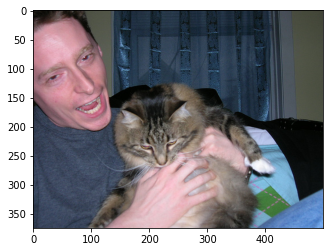

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


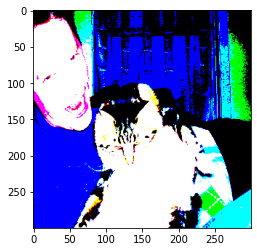

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


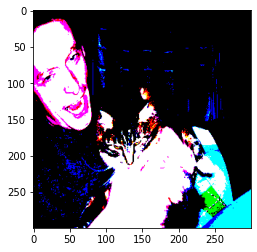

In [143]:
# OpenCV2のインポート
import cv2
from google.colab.patches import cv2_imshow

import matplotlib.pyplot as plt
%matplotlib inline

# 動作確認用イメージの高さ、幅、チャネル数を取得
# 19番目のインデックスを指定してイメージのパスを取得
img_filepath = tr_img[19]
# opencv2でイメージを[高さ、幅、[G,B,R]]のリストに読み込む
img = cv2.imread(img_filepath)
# 配列要素を数えて高さ、幅のみを変数に格納
height, width, _ = img.shape

# 正解ラベルを引数にしてGetBBoxAndLabelを生成
gb1 = GetBBoxAndLabel(voc_labels)
# 19番目のBBoxの多重リストを取得
# [[xmin, ymin, xmax, ymax, 正解ラベルのインデックス]]
bbox_label = gb1(tr_anno[19], width, height)

# オリジナルのイメージを表示
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# VOCデータセットのRGBの各値の平均値は(R)123, (G)117, (B)104
# これをOpenCVのRGBの並び順に合わせる
color_mean = (104, 117, 123)
input_size = 300
# 前処理オブジェクトを生成
transform = DataTransform(input_size, color_mean)

# 訓練時の拡張処理後のイメージを表示
# 訓練モード
phase = 'train'
# 訓練時の前処理を実施
img_transformed, boxes, labels = transform(
    img,
    phase,
    bbox_label[:, :4],
    bbox_label[:, 4]
)
# 処理後のイメージを出力
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()

# 検証時の拡張処理後のイメージを表示
# 検証モード
phase = 'val'
# 検証時の前処理を実施
img_transformed, boxes, labels = transform(
    img,
    phase,
    bbox_label[:, :4],
    bbox_label[:, 4]
)
# 処理後のイメージを出力
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()

In [144]:
'''
4. データセットの数だけ繰り返し呼ばれる前処理オブジェクトを生成
    __getitem()__()は1データにつき前処理後のイメージ、BBoxとラベルの配列を返す
'''
import torch
import torch.utils.data as data
import cv2

class PreprocessVOC2012(data.Dataset):
    '''
    PyTorchのDatasetクラスを継承
        DataTransformでVOC2012データセットを前処理して以下のデータを返す
        ・前処理後のイメージ[R,G,B](Tensor)
        ・BBoxとラベル(ndarray)
        ・イメージの高さ、幅
        Datasetは__geiitem__()と__len__()の実装が必要
    '''
    def __init__(self, img_list, anno_list, phase, transform, get_bbox_label):
        '''
        Parameters:
            img_list(list): イメージのファイルパスを格納したリスト
            anno_list(list): アノテーションのファイルパスを格納したリスト
            phase(str): trainまたはtestで訓練か検証かを判定
            transform(object): 前処理クラスDataTransform
            bbox_label(object): BBox座標と正解ラベルを取得するGetBBoxAndLabel
        '''
        self.img_list = img_list
        self.anno_list = anno_list
        self.phase = phase
        self.transform = transform
        self.get_bbox_label = get_bbox_label
    
    def __len__(self):
        '''
        イメージの数を返す
        '''
        return len(self.img_list)
    
    def __getitem__(self, index):
        '''
        データの数だけイテレート（反復処理）される
        前処理後のイメージ、BBox座標とラベルの2次元配列を取得する
        Parameters:
            index(int): 訓練または検証用イメージのインデックス
        Returns:
            im(Tensor): 前処理後のイメージを格納した3階テンソル
            b1(ndarray): BBoxとラベルの2次元配列
        '''
        # pull_item()にイメージのインデックスを渡して前処理
        # 処理後のイメージデータとBBoxとラベルの2次元配列を返す
        im, b1, _, _ = self.pull_item(index)
        return im, b1
    
    def pull_item(self, index):
        '''
        前処理後のテンソル形式のイメージデータ、アノテーション、イメージの高さ、幅を取得する

        Parameters：
            index(int): 訓練または検証用イメージのインデックス
        
        Returns:
            img(Tensor): 前処理後のイメージ（3、高さのピクセル数、幅のピクセル数）
            box1b1(ndarray): BBoxとラベルの2次元配列
            height(int): イメージの高さ
            width(int): イメージの幅
        '''
        # イメージの高さ、幅、チャネル数を取得
        img_path = self.img_list[index]
        img = cv2.imread(img_path)
        height, width, _ = img.shape

        # アノテーションデータのリストを取得
        # インデックスを指定してアノテーションファイル（xml）のパスを取得
        anno_file_path = self.anno_list[index]
        # アノテーションファイルからBBoxの座標、正解ラベルのリストを取得
        bbox_label = self.get_bbox_label(anno_file_path, width, height)

        # DataTransformで前処理を実施
        img, boxes, labels = self.transform(
            img,
            self.phase,
            bbox_label[:, :4],
            bbox_label[:, 4],
        )

        # img(ndarray)の形状は（高さのピクセル数、幅のピクセル数、3）
        # 3はBGRの並びなのでこれをRGBの順に変更
        # (3, 高さのピクセル数、幅のピクセル数)の形状の3階テンソルにする
        img = torch.from_numpy(
            img[:, :, (2, 1, 0)]
        ).permute(2, 0, 1)

        # [label, label, ...]を[[label], [label], ...]にように次元拡張して
        # [[xmin, ymin, xmax, ymax], ...]と水平方向に連結し、
        # [[xmin, ymin, xmax, ymax, label], ...]の形状にする
        box1b1 = np.hstack(
            (boxes, np.expand_dims(labels, axis=1))
        )

        # 前処理後のイメージ[R,G,B]、BBoxとラベルのndarray
        # イメージの高さ、幅を返す
        return img, box1b1, height, width

In [145]:
# VOCデータセットのRGBの各種の平均値
# (R)123, (G)117, (B)104
color_mean = (104, 117, 123)
input_size = 300

tr_data = PreprocessVOC2012(
    tr_img,
    tr_anno,
    phase='train',
    transform=DataTransform(input_size, color_mean),
    get_bbox_label=GetBBoxAndLabel(voc_labels)
)

val_data = PreprocessVOC2012(
    val_img,
    val_anno,
    phase='val',
    transform=DataTransform(input_size, color_mean),
    get_bbox_label=GetBBoxAndLabel(voc_labels)
)

# 訓練用のインデックス1のイメージを前処理して出力
batch = tr_data.__getitem__(1)
print(len(batch))
print(batch[0].shape)
print(batch[1].shape)
print(batch)

2
torch.Size([3, 300, 300])
(2, 5)
(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]), array([[0.56696429, 0.32650273, 0.66339286, 0.56557377, 4.        ],
       [0.37678571, 0.32650273, 0.47232143, 0.53005464, 4.        ]]))


In [146]:
'''
5. ミニバッチを作る関数
'''
def multiobject_collate_fn(batch):
    '''
    PyTorchのcollate_fn()をカスタマイズ
    イメージとイメージに対応するアノテーション（複数あり）を
    ミニバッチの数だけ生成する機能を実装

    Parameters:
        batch(tuple):
            PreprocessVOC2012の__geiitem__()で返される要素数2のタプル
    
    Returns:
        imgs(Tensor):
            前処理後のイメージ（RGB）をミニバッチの数だけ格納した4階テンソル
            形状は（ミニバッチのサイズ3、300、300）
        targets(list):
            [[xmin, ymin, xmax, ymax, label], ...]の2階テンソル([物体数,5])
            を格納したリスト、要素数はミニバッチの数
    '''
    imgs = []
    targets = []

    # ミニバッチの前処理後のイメージをimgsに追加
    # ミニバッチのBBox座標とラベルの2次元配列をtargetsに追加
    for sample in batch:
        # sample[0]はイメージデータ[R,G,B](torch.size([3,300,300]))
        imgs.append(sample[0])
        # sample[1]はBBox座標とラベルの2次元配列
        # これをTensorにしてリストtargetsに追加
        targets.append(torch.FloatTensor(sample[1]))
    
    # リストimgsの要素torch.Size([3,300,300])の0次元を拡張して
    # (ミニバッチのサイズ、3,300、300)の4階テンソル
    imgs = torch.stack(imgs, dim=0)

    # targetsは[[xmin, ymin, xmax, ymax, label], ...]の2階テンソル
    # 即ち[[物体数、5]]の2階テンソルをミニバッチの数だけ格納したリスト
    # リストの中身は[[物体数、5], [物体数、5],...]となる
    return imgs, targets

In [147]:
import torch.utils.data as data

# ミニバッチのサイズ
batch_size = 4

# 訓練データのミニバッチ
tr_batch = data.DataLoader(
    tr_data,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=multiobject_collate_fn
)

# 検証データのミニバッチ
val_batch = data.DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=multiobject_collate_fn
)

# train val をキーにして辞書にまとめる
dataloader_dict = {'train': tr_batch, 'val': val_batch}

# 動作の確認
print('訓練データのサイズ：', tr_data.__len__())
print('検証データのサイズ：', val_data.__len__())
print('訓練データのミニバッチの個数：', len(dataloader_dict['train']))
print('検証データのミニバッチの個数：', len(dataloader_dict['val']))

# 訓練用のDataLoaderをイテレーターに変換
batch_iterator = iter(dataloader_dict['train'])
# 訓練用の1番目のミニバッチを取り出す
images, targets = next(batch_iterator)
print('ミニバッチのイメージの形状：', images.size())
print('ミニバッチのtargetsのサイズ：', len(targets))
print('targets[1]の形状：', targets[1].size())

訓練データのサイズ： 5717
検証データのサイズ： 5823
訓練データのミニバッチの個数： 1430
検証データのミニバッチの個数： 1456
ミニバッチのイメージの形状： torch.Size([4, 3, 300, 300])
ミニバッチのtargetsのサイズ： 4
targets[1]の形状： torch.Size([1, 5])
